In [1]:
# Parameters
artificial_humans = {
    "full": {
        "contribution_model": "artifacts/behavioral_cloning/21_contribution_model_v4/model/architecture_node+edge+rnn__dataset_full.pt",
        "valid_model": "artifacts/behavioral_cloning/22_contribution_valid_model_v4/model/rnn_False__dataset_full.pt",
    },
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "artifacts/behavioral_cloning/23_punishment_autoregressive_v4/model/architecture_node+edge.pt",
        "autoregressive": True,
    },
    "pgh,γ=0.98": {
        "type": "rl",
        "path": "artifacts/manager/17_exp2_group_payoff_heavy_optimize/model/_manager.pt",
    },
    "ci,γ=0.9": {
        "type": "rl",
        "path": "artifacts/manager/09_exp2_gamma_9/model/_manager.pt",
    },
    "ci,γ=0.7": {
        "type": "rl",
        "path": "artifacts/manager/19_exp2_gamma_7_heavy/model/_manager.pt",
    },
}
n_episode_steps = 24
n_episodes = 100
output_dir = "../../notebooks/test_manager/simulate_group_selection/01_all_artifacts"
basedir = "../.."

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import random
from itertools import count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
from tqdm import tqdm

from aimanager.artificial_humans import GraphNetwork
from aimanager.manager.api_manager import MultiManager
from aimanager.manager.environment import ArtificialHumanEnv
from aimanager.manager.memory import Memory
from aimanager.utils.array_to_df import add_labels, using_multiindex
from aimanager.utils.utils import make_dir

plot_folder = output_dir

make_dir(plot_folder)

managers = {k:{**v, 'model_path': os.path.join(basedir, v['path'])} for k,v in managers.items()}
managers

{'humanlike': {'type': 'human',
  'path': 'artifacts/behavioral_cloning/23_punishment_autoregressive_v4/model/architecture_node+edge.pt',
  'autoregressive': True,
  'model_path': '../../artifacts/behavioral_cloning/23_punishment_autoregressive_v4/model/architecture_node+edge.pt'},
 'pgh,γ=0.98': {'type': 'rl',
  'path': 'artifacts/manager/17_exp2_group_payoff_heavy_optimize/model/_manager.pt',
  'model_path': '../../artifacts/manager/17_exp2_group_payoff_heavy_optimize/model/_manager.pt'},
 'ci,γ=0.9': {'type': 'rl',
  'path': 'artifacts/manager/09_exp2_gamma_9/model/_manager.pt',
  'model_path': '../../artifacts/manager/09_exp2_gamma_9/model/_manager.pt'},
 'ci,γ=0.7': {'type': 'rl',
  'path': 'artifacts/manager/19_exp2_gamma_7_heavy/model/_manager.pt',
  'model_path': '../../artifacts/manager/19_exp2_gamma_7_heavy/model/_manager.pt'}}

In [3]:
def mem_to_df(recorder, name):
    columns = ["episode", "participant_code", "round_number"]

    punishments = using_multiindex(
        recorder.memory["punishment"].squeeze(1).numpy(),
        columns=columns,
        value_name="punishment",
    )
    common_good = using_multiindex(
        recorder.memory["common_good"].squeeze(1).numpy(),
        columns=columns,
        value_name="common_good",
    )
    contributions = using_multiindex(
        recorder.memory["contribution"].squeeze(1).numpy(),
        columns=columns,
        value_name="contribution",
    )
    group = using_multiindex(
        recorder.memory["group"].squeeze(1).numpy(), columns=columns, value_name="group"
    )

    df_sim = punishments.merge(common_good).merge(contributions).merge(group)

    df_sim["participant_code"] = (
        df_sim["participant_code"].astype(str) + "_" + df_sim["episode"].astype(str)
    )

    df_sim["run"] = name
    return df_sim


def make_round(contributions, round, groups, episode_group_idx):
    return {
        "contribution": contributions,
        "contribution_valid": [c is not None for c in contributions],
        "punishment_valid": [False] * len(contributions),
        "punishment": [None] * len(contributions),
        "group": groups,
        "round": round,
        "episode_group_idx": episode_group_idx,
    }


def add_punishments(round, punishments):
    return {
        **round,
        "punishment": punishments,
        "punishment_valid": [p is not None for p in punishments],
    }

In [4]:
# def _get_better_avg_movement_map(self):
#     avg_payoffs = [group.average_contributor_payoff for group in self.human_groups]
#     max_idx, max_avg = max(enumerate(avg_payoffs), key=itemgetter(1))
#     move_map: dict[tuple, int] = {}
#     for gid, group in enumerate(self.human_groups):
#         for aid in range(group.n_agents):
#             if group.contributor_payoff[0, aid] < max_avg:
#                 move_map[(gid, aid)] = max_idx
#             else:
#                 move_map[(gid, aid)] = gid

In [5]:
def update_groups(recorder, groups, round_number, horizon):
    new_groups = []
    for i in range(n_groups):
        if punishments[i] is not None:
            new_groups.append(groups[punishments[i]])
        else:
            new_groups.append(groups[contributions[i]])
    return new_groups

In [6]:
# round_number = 3
# horizon = 4

# contributor_payoff = recorder.memory['contributor_payoff']
# group = recorder.memory['group']
# relevant_contributor_payoff = contributor_payoff[:, :, :, round_number - horizon + 1:round_number + 1]
# relevant_group = group[:, :, round_number - horizon + 1:round_number + 1]

In [7]:
# env = ArtificialHumanEnv(
#     artifical_humans=ah,
#     artifical_humans_valid=ah_val,
#     n_agents=n_agents, n_contributions=21, n_punishments=31,
#     n_rounds=n_episode_steps, batch_size=1, n_groups=2, device=device)


# agent_groups = th.tensor([[0]*4 + [1]*4])

# env.update_groups(agent_groups)

In [8]:
def assign_group_idx(groups):
    unique_groups = list(set(groups))
    unique_groups.sort(key=lambda x: int(x == "humanlike"), reverse=True)
    g_name_to_idx = {g: i for i, g in enumerate(unique_groups)}
    gidx_to_name = {i: g for i, g in enumerate(unique_groups)}
    return g_name_to_idx, gidx_to_name


def get_agent_groups(groups, g_name_to_idx):
    return th.tensor([[g_name_to_idx[g] for g in groups]])


def change_groups_common_good(
    recorder,
    round_number,
    horizon,
    episode,
    gidx_to_name,
    stay_prob: float = 0.0,
):
    common_good = recorder.memory["common_good"]
    groups = recorder.memory["group"]

    avg_common_good = common_good[
        episode, 0, :, round_number - horizon + 1 : round_number + 1
    ].mean(-1)

    old_groups = groups[episode, 0, :, round_number]
    agent_group_mask = th.nn.functional.one_hot(
        old_groups, num_classes=old_groups.max() + 1
    )
    # We can do max here as common good is the same for all group members
    group_common_good = (avg_common_good.unsqueeze(-1) * agent_group_mask).sum(-2) / (
        agent_group_mask.sum(-2) + 1e-6
    )

    best_group_common_good, best_group_idx = group_common_good.max(-1)

    contributor_cg_below_best = avg_common_good < best_group_common_good.unsqueeze(-1)

    groups = th.where(contributor_cg_below_best, best_group_idx, old_groups)
    groups = th.where(th.rand(len(groups)) > stay_prob, groups, old_groups)

    groups = [gidx_to_name[g.item()] for g in groups]
    return groups


def change_groups_payoff(
    recorder,
    round_number,
    horizon,
    episode,
    gidx_to_name,
    stay_prob: float = 0.0,
):
    group_payoff = recorder.memory["group_payoff"]
    contributor_payoff = recorder.memory["contributor_payoff"]
    groups = recorder.memory["group"]

    assert group_payoff.shape[1] == 1
    assert contributor_payoff.shape[1] == 1

    avg_group_payoff = group_payoff[
        episode, 0, :, round_number - horizon + 1 : round_number + 1
    ].mean(-1)
    avg_contributor_payoff = contributor_payoff[
        episode, 0, :, round_number - horizon + 1 : round_number + 1
    ].mean(-1)
    old_groups = groups[episode, 0, :, round_number]

    best_group_payoff, best_group_idx = avg_group_payoff.max(-1)

    contributor_payoff_below_best = (
        avg_contributor_payoff < best_group_payoff.unsqueeze(-1)
    )

    groups = th.where(contributor_payoff_below_best, best_group_idx, old_groups)
    groups = th.where(th.rand(len(groups)) > stay_prob, groups, old_groups)

    groups = [gidx_to_name[g.item()] for g in groups]

    return groups

In [10]:
device = th.device("cpu")
rec_device = th.device("cpu")

mm = MultiManager(
    managers,
    n_steps=n_episode_steps,
)

# fix bug
for k, man in mm.managers.items():
    if "autoregressive" in managers[k]:
        man.model.autoregressive = managers[k]["autoregressive"]

n_agents = 8

group_change_freq = 4
group_stay_prob = 0.5

artificial_human = artificial_humans["full"]
manager = list(managers.keys())

# runs = {
#     f"managed by {m}": {'groups': [m]*n_agents, 'humans': 'full'}
#     for m in manager
# }

runs = dict()
runs["pgh,γ=0.98|p"] = {
    "groups": ["humanlike"] * (n_agents // 2) + ["pgh,γ=0.98"] * (n_agents // 2),
    "humans": "full",
    "objective": "payoff",
}
runs["pgh,γ=0.98|cg"] = {
    "groups": ["humanlike"] * (n_agents // 2) + ["pgh,γ=0.98"] * (n_agents // 2),
    "humans": "full",
    "objective": "common_good",
}
runs["ci,γ=0.9|p"] = {
    "groups": ["humanlike"] * (n_agents // 2) + ["ci,γ=0.9"] * (n_agents // 2),
    "humans": "full",
    "objective": "payoff",
}
runs["ci,γ=0.9|cg"] = {
    "groups": ["humanlike"] * (n_agents // 2) + ["ci,γ=0.9"] * (n_agents // 2),
    "humans": "full",
    "objective": "common_good",
}
runs["ci,γ=0.7|p"] = {
    "groups": ["humanlike"] * (n_agents // 2) + ["ci,γ=0.7"] * (n_agents // 2),
    "humans": "full",
    "objective": "payoff",
}
runs["ci,γ=0.7|cg"] = {
    "groups": ["humanlike"] * (n_agents // 2) + ["ci,γ=0.7"] * (n_agents // 2),
    "humans": "full",
    "objective": "common_good",
}
objective_fn_map = {
    "payoff": change_groups_payoff,
    "common_good": change_groups_common_good,
}

dfs = []
for name, run in tqdm(runs.items()):
    n_agents = len(run["groups"])
    g_name_to_idx, gidx_to_name = assign_group_idx(run["groups"])
    n_groups = len(g_name_to_idx)

    hm_path = os.path.join(
        basedir, artificial_humans[run["humans"]]["contribution_model"]
    )
    hmv_path = os.path.join(basedir, artificial_humans[run["humans"]]["valid_model"])

    ah = GraphNetwork.load(hm_path, device=device)
    ah_val = GraphNetwork.load(hmv_path, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah,
        artifical_humans_valid=ah_val,
        n_agents=n_agents,
        n_contributions=21,
        n_punishments=31,
        n_rounds=n_episode_steps,
        batch_size=1,
        n_groups=n_groups,
        device=device,
    )
    recorder = Memory(
        n_episodes=n_episodes,
        n_episode_steps=n_episode_steps,
        output_file=None,
        device=device,
    )
    for e in range(n_episodes):
        groups = run["groups"]
        state = env.reset()
        env.update_groups(get_agent_groups(groups, g_name_to_idx))
        episode_group_idx = random.randint(0, 1000000)
        rounds = []
        for round_number in count():
            contributions = state["contribution"].squeeze().tolist()
            round = make_round(contributions, round_number, groups, episode_group_idx)
            punishments = mm.get_punishments(rounds + [round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments.unsqueeze(-1).unsqueeze(0))
            recorder.add(
                **{
                    k: v if len(v.shape) == 3 else v.unsqueeze(-1)
                    for k, v in state.items()
                },
                episode_step=round_number,
            )
            state, reward, done = env.step()
            if done:
                break
            if (round_number + 1) % group_change_freq == 0:
                groups = objective_fn_map[run["objective"]](
                    recorder,
                    round_number,
                    group_change_freq,
                    e,
                    gidx_to_name,
                    stay_prob=group_stay_prob,
                )
                env.update_groups(get_agent_groups(groups, g_name_to_idx))
        recorder.next_episode(e)
    some_df = mem_to_df(recorder, name=name)
    some_df["manager"] = some_df["group"].map(gidx_to_name)
    some_df["objective"] = run["objective"]
    dfs.append(some_df)

100%|██████████| 6/6 [08:32<00:00, 85.37s/it]


In [11]:
df = pd.concat(dfs)
df["payoff"] = 20 - df["contribution"] - df["punishment"] + df["common_good"]

In [12]:
dfg = (
    df.groupby(["run", "episode", "round_number", "manager"])
    .count()
    .reset_index()
    .rename(columns={"participant_code": "n_agents"})[
        ["run", "episode", "round_number", "manager", "n_agents"]
    ]
)
df = pd.merge(dfg, df, on=["run", "episode", "round_number", "manager"])

In [13]:
dfg = (
    df.groupby(["run", "episode", "round_number", "group"])
    .mean(numeric_only=True)
    .reset_index()
)

In [14]:
dfg

,run,episode,round_number,group,n_agents,punishment,common_good,contribution,payoff
0,"ci,γ=0.7|cg",0,0,0,4.0,1.00,10.600000,7.250000,22.350000
1,"ci,γ=0.7|cg",0,0,1,4.0,1.75,17.850000,12.250000,23.850000
2,"ci,γ=0.7|cg",0,1,0,4.0,1.75,9.050000,6.750000,20.550000
3,"ci,γ=0.7|cg",0,1,1,4.0,2.00,17.600000,12.250000,23.350000
4,"ci,γ=0.7|cg",0,2,0,4.0,0.25,4.150000,2.750000,21.150000
...,...,...,...,...,...,...,...,...,...
24959,"pgh,γ=0.98|p",99,21,1,7.0,0.00,25.371429,15.857143,29.514287
24960,"pgh,γ=0.98|p",99,22,0,1.0,0.00,0.000000,0.000000,20.000000
24961,"pgh,γ=0.98|p",99,22,1,7.0,0.00,24.960001,15.428571,29.531430
24962,"pgh,γ=0.98|p",99,23,0,1.0,15.00,-15.000000,0.000000,-10.000000


<Axes: xlabel='n_agents', ylabel='Density'>

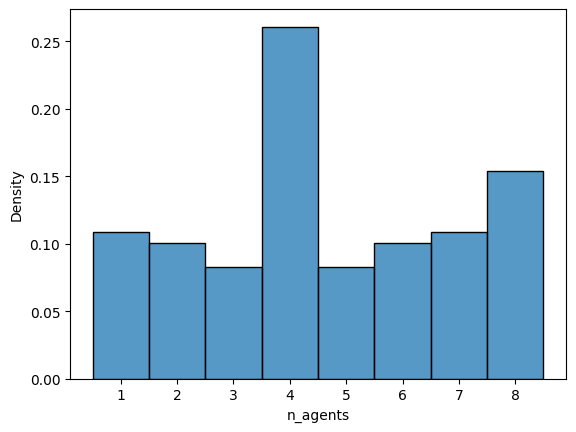

In [19]:
sns.histplot(dfg, x="n_agents", stat="density", common_norm=False, discrete=True)

In [16]:
df[df["n_agents"] == 1]["contribution"].mean()

11.535661764705882

<Axes: xlabel='n_agents', ylabel='contribution'>

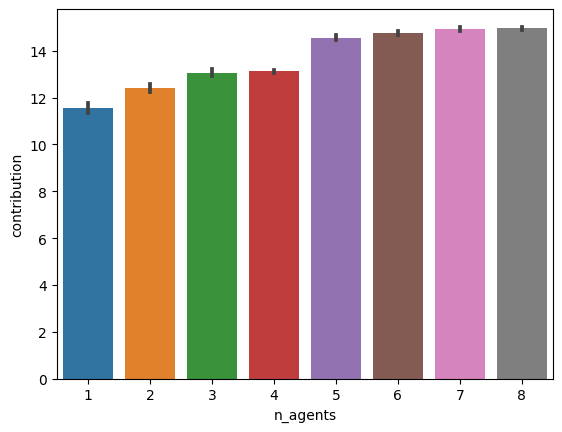

In [18]:
sns.barplot(data=df, x="n_agents", y="contribution")

In [21]:
df["episode"] = df["run"] + "__" + df["episode"].astype(str)

dfm = df.melt(
    id_vars=[
        "episode",
        "round_number",
        "participant_code",
        "run",
        "manager",
        "group",
        "objective",
    ],
    value_vars=["punishment", "contribution", "common_good"],
)

In [22]:
dfm

,episode,round_number,participant_code,run,manager,group,objective,variable,value
0,"ci,γ=0.7|cg__ci,γ=0.7|cg__0",0,4_0,"ci,γ=0.7|cg","ci,γ=0.7",1,common_good,punishment,1.0
1,"ci,γ=0.7|cg__ci,γ=0.7|cg__0",0,5_0,"ci,γ=0.7|cg","ci,γ=0.7",1,common_good,punishment,1.0
2,"ci,γ=0.7|cg__ci,γ=0.7|cg__0",0,6_0,"ci,γ=0.7|cg","ci,γ=0.7",1,common_good,punishment,1.0
3,"ci,γ=0.7|cg__ci,γ=0.7|cg__0",0,7_0,"ci,γ=0.7|cg","ci,γ=0.7",1,common_good,punishment,4.0
4,"ci,γ=0.7|cg__ci,γ=0.7|cg__0",0,0_0,"ci,γ=0.7|cg",humanlike,0,common_good,punishment,0.0
...,...,...,...,...,...,...,...,...,...
345595,"pgh,γ=0.98|p__pgh,γ=0.98|p__99",23,3_99,"pgh,γ=0.98|p","pgh,γ=0.98",1,payoff,common_good,25.6
345596,"pgh,γ=0.98|p__pgh,γ=0.98|p__99",23,4_99,"pgh,γ=0.98|p","pgh,γ=0.98",1,payoff,common_good,25.6
345597,"pgh,γ=0.98|p__pgh,γ=0.98|p__99",23,5_99,"pgh,γ=0.98|p","pgh,γ=0.98",1,payoff,common_good,25.6
345598,"pgh,γ=0.98|p__pgh,γ=0.98|p__99",23,6_99,"pgh,γ=0.98|p","pgh,γ=0.98",1,payoff,common_good,25.6


In [23]:
df["group"] = df["group"].astype(float)

In [28]:
df_avg = (
    df.groupby(["round_number", "run", "objective"])
    .mean(numeric_only=True)
    .reset_index()
)

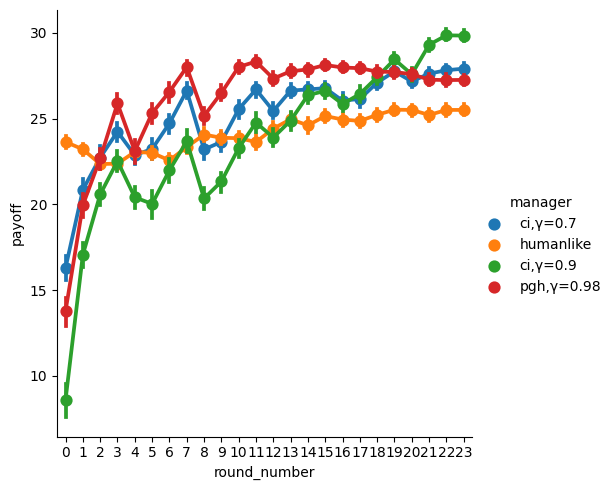

In [25]:
sns.catplot(data=df, x="round_number", y="payoff", hue="manager", kind="point")

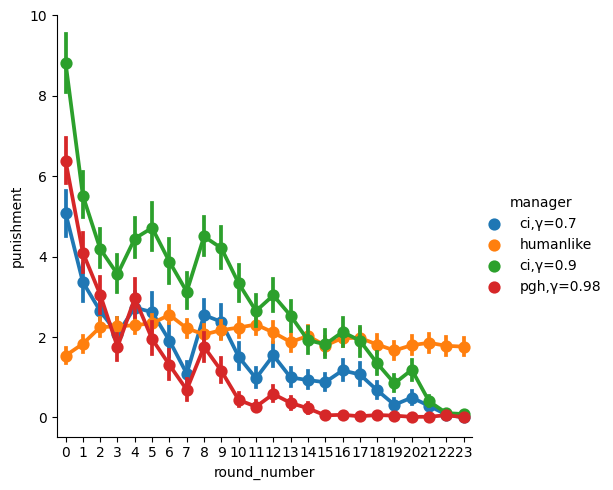

In [26]:
sns.catplot(data=df, x="round_number", y="punishment", hue="manager", kind="point")

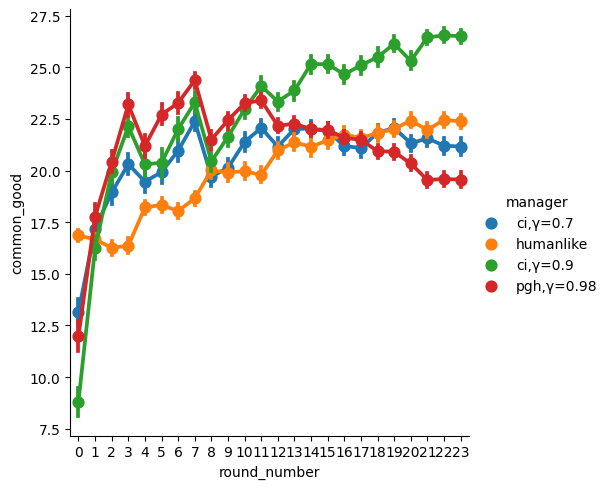

In [27]:
sns.catplot(data=df, x="round_number", y="common_good", hue="manager", kind="point")

Text(0.5, 1.0, 'Switching with prob 0.5 if common good is lower than best group')

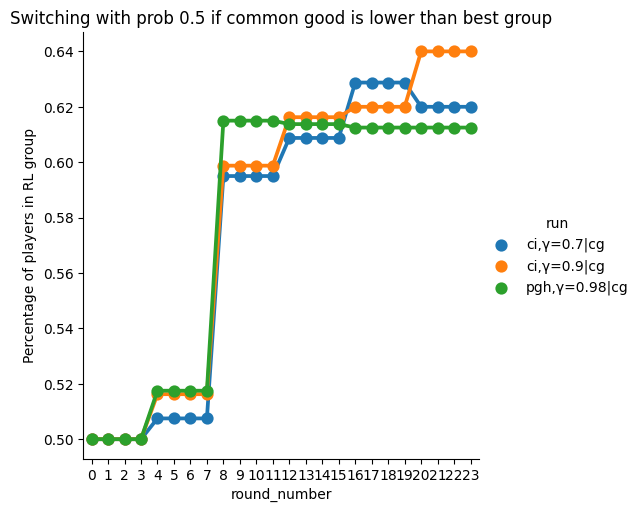

In [32]:
sns.catplot(
    data=df_avg[df_avg["objective"] == "common_good"],
    x="round_number",
    y="group",
    hue="run",
    kind="point",
)
plt.ylabel("Percentage of players in RL group")
plt.title("Switching with prob 0.5 if common good is lower than best group")

Text(0.5, 1.0, 'Switching with prob 0.5 if payoff is lower than best group')

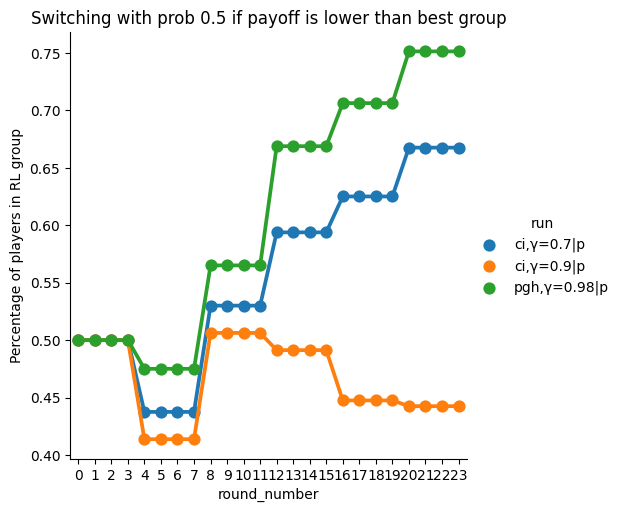

In [33]:
sns.catplot(
    data=df_avg[df_avg["objective"] == "payoff"],
    x="round_number",
    y="group",
    hue="run",
    kind="point",
)
plt.ylabel("Percentage of players in RL group")
plt.title("Switching with prob 0.5 if payoff is lower than best group")

<Axes: xlabel='manager', ylabel='punishment'>

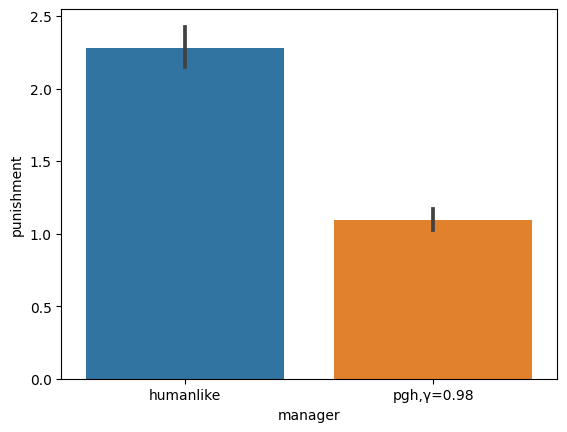

In [43]:
sns.barplot(data=df, x="manager", y="punishment")

In [26]:
recorder.memory["group"][:, 0, :, :].type(th.float).mean(1).mean(0)[::4]

tensor([0.5000, 0.4375, 0.5725, 0.6263, 0.6488, 0.6712])